In [271]:
import random

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.stats import expon

pd.set_option('display.max_rows', 100, 'display.max_columns', 100)


from matplotlib.colors import ListedColormap
import matplotlib as mpl
COLOR = 'white'
mpl.rcParams['text.color'] = "black"
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR


from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.preprocessing import StandardScaler

from nptyping import NDArray, Float64, Shape

from plotting.plot_funcs import plot_cluster


In [272]:
from data_simulation.simulate_data import Experiment
exp1 = Experiment(max_cluster_number=6)
df = exp1.df
X = exp1.X
X.shape

(204, 2)

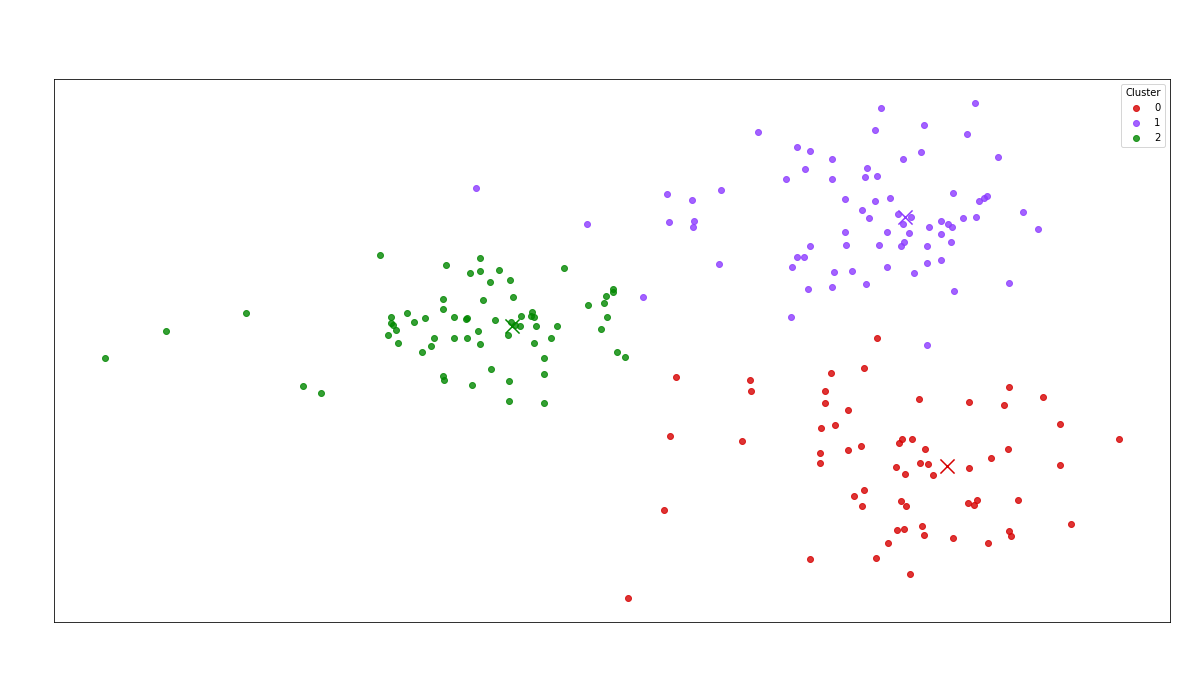

In [273]:
plot_cluster(exp1.df, "cluster", title="True Clusters")

In [274]:
from cem_algorithm.cem_funcs import p, pdfs
from copy import deepcopy

In [1043]:
from cluster_initialization.init_class import Cluster_initialization, Routine

cluster_init = Cluster_initialization(exp1.df, routine = Routine.random_inside)


In [1092]:
k_min, k_max = 1, 10
epsilon = 1e-4

cluster_init.sample(N_cluster_max=k_max, N_runs_per_clusternumber=1)
init_params_array = cluster_init.sampled_init_params_array[-1]
params_array = deepcopy(init_params_array)
params_array.shape

(40,)

Before while loop

In [1093]:
# setting start values
t = 0
k_nz = k_max

# evaluating the pdfs for every point for every cluster
N = X.shape[0]
K = len(params_array)//4
d = 3  # number of paramters for one mixture


In [1094]:
from numba import njit
from scipy.optimize import minimize

def calc_gammas(X, params_array):
    pdf_array = pdfs(X, params_array)
    return ((params_array[::4] * pdf_array).T / np.sum((params_array[::4] * pdf_array), axis=1)).T  # transposing because of broadcasting


def M_step(X, params_array, gammas, k):
    """minimize log likelihood
    """
    constr = (#{"type": "eq", "fun": lambda x: np.sum(x[::4])-1},  # nebenbedingung
              {"type": "ineq", "fun": lambda x: x - 1e-06})     # parameters must be positive

    param_opt = params_array[4*k+1 : 4*(k+1)]
    minimizer = minimize(
        cdll_optimize, 
        x0=param_opt, # initial values
        constraints=constr,
        args = (X, params_array, gammas, k), 
        method="SLSQP",
        options = {
            "maxiter": 300,
            "eps": 1e-10,
            #"ftol": 1e-03
        } 
    )
    return minimizer.x

@njit(fastmath=True, cache=True)
def cdll_optimize(params_opt: np.ndarray, X: np.ndarray, params_array: np.ndarray, gammas: np.ndarray, k) -> np.ndarray:
    params_array[4*k+1 : 4*(k+1)] = params_opt
    pdfs_ = pdfs(X, params_array)
    mix_coeffs = params_array[::4]
    return -np.sum( gammas * (np.log(mix_coeffs) + np.log(pdfs_))) # K x N * (K x N).T = K

@njit(fastmath=True, cache=True)
def ll_optimize(params_opt: np.ndarray, X: np.ndarray, params_array: np.ndarray, gammas: np.ndarray, k) -> np.ndarray:
    params_array[4*k+1 : 4*(k+1)] = params_opt
    pdfs_ = pdfs(X, params_array)
    mix_coeffs = params_array[::4]
    return -np.sum(np.log(np.sum(mix_coeffs*pdfs_, axis=1)))  # K x N * (K x N).T = K

def cdll( X: np.ndarray, params_array: np.ndarray, gammas: np.ndarray) -> np.ndarray:
    gammas = calc_gammas(X, params_array)
    pdfs_ = pdfs(X, params_array)
    mix_coeffs = params_array[::4]
    return np.sum( gammas * (np.log(mix_coeffs) + np.log(pdfs_))) # K x N * (K x N).T = K

def ll( X: np.ndarray, params_array: np.ndarray, gammas: np.ndarray) -> np.ndarray:
    gammas = calc_gammas(X, params_array)
    pdfs_ = pdfs(X, params_array)
    mix_coeffs = params_array[::4]
    return np.sum(np.log(np.sum(mix_coeffs*pdfs_, axis=1))) # K x N * (K x N).T = K

def compute_MML(X, params_array): # original cost function in paper
    n_points = X.shape[0]
    n_components = params_array.shape[0]//4
    gammas = calc_gammas(X, params_array)
    loglikelihood = ll(X, params_array, gammas)
    return 3/2 * np.sum(np.log(params_array[::4] * n_points/12)) + 1/2 * n_components * np.log(n_points/12) + 1/2 * n_components*4  - loglikelihood

def compute_MML2(X, params_array):
    n_points = X.shape[0]
    n_components = params_array.shape[0]//4
    gammas = calc_gammas(X, params_array)
    loglikelihood = ll(X, params_array, gammas)
    return 3/2 * np.sum(np.log(params_array[::4])) + 1/2 * n_components*4 * np.log(n_points) - loglikelihood

In [1095]:
def CEMM(X, params_array):
    best_params = []
    Ls = [1e10]
    costs = [1e10]
    epsilon_L = 1e-8
    d=5
    t = 0
    k_nz = k_max
    active_components = params_array[::4] > 0
    while k_nz >= k_min:
        t += 1
        L_converged = False
        print(t)
        while not L_converged:
            for k in range(0, k_max):  # "m" in paper
                if active_components[k]:
                    print(params_array[::4])
                    # compute responsibilities (gammas)
                    gammas = calc_gammas(X, params_array)
                    # calculate new mixture coefficient for cluster m
                    support = np.sum(gammas, axis=0) - d/2 
                    mix_coef_k = support[k] / np.sum(np.where(support < 0 , 0, support))     # paper:  - N/2  which accounts only for the parameters specifying the components distribution
                    # updating all mixture coefficients
                    params_array[4*k] = max(0, mix_coef_k) 
                    params_array[::4] =  params_array[::4] / params_array[::4].sum()
                    active_components = params_array[::4] > 0
                    active_params = np.repeat(active_components, 4)
                    # Maximization step
                    if params_array[4*k] > 0:
                        gammas = calc_gammas(X, params_array[active_params])  # gammas changed because of mixture coefficients
                        i = sum(active_components[:k])
                        params_opt = M_step(X, params_array[active_params], gammas, i)
                        params_array[1+4*k: 4*(k+1)] = params_opt
                    else:
                        k_nz -= 1  
            gammas = calc_gammas(X, params_array[active_params])
            L = ll(X, params_array[active_params], gammas)
            Ls.append(L)
            best_params.append(deepcopy(params_array[active_params]))
            cost = compute_MML(X, params_array[active_params])
            if np.isnan(cost): #BUG
                cost = compute_MML(X, params_array[active_params])
                raise ValueError
            costs.append(cost)
            print()
            #if abs(costs[-1] - costs[-2]) < abs(epsilon_L * costs[-2]):
            if 0 <= Ls[-1] - Ls[-2] < epsilon_L:
                print(f"{t} step converged")
                print(f"{costs[-1] - costs[-2]},  {costs[-2]},  {costs[-2]}  ")
                print(f"n_cluster: {sum(active_components)}")
                L_converged = True
                valid_idx = np.where(params_array[::4] > 0)[0]
                idx_kill = valid_idx[params_array[::4][valid_idx].argmin()]
                params_array[4*idx_kill] = 0
                active_components[idx_kill] = False
                active_params = np.repeat(active_components, 4)
                if sum(params_array[::4]) > 0:
                    params_array[::4] =  params_array[::4] / params_array[::4].sum()
                k_nz -= 1
    return best_params, Ls, costs
            

In [1096]:
best_params, Ls, costs = CEMM(X, params_array)

1
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.06097573 0.10433603 0.10433603 0.10433603 0.10433603 0.10433603
 0.10433603 0.10433603 0.10433603 0.10433603]
[0.05916152 0.1309848  0.10123171 0.10123171 0.10123171 0.10123171
 0.10123171 0.10123171 0.10123171 0.10123171]
[0.05974794 0.13228316 0.0923229  0.10223514 0.10223514 0.10223514
 0.10223514 0.10223514 0.10223514 0.10223514]
[0.05840824 0.12931702 0.09025278 0.12236536 0.09994277 0.09994277
 0.09994277 0.09994277 0.09994277 0.09994277]
[0.06055409 0.13406798 0.09356856 0.12686092 0.06687569 0.10361455
 0.10361455 0.10361455 0.10361455 0.10361455]
[0.0525323  0.11630757 0.08117324 0.11005525 0.05801646 0.22236157
 0.0898884  0.0898884  0.0898884  0.0898884 ]
[0.04849859 0.10737687 0.07494033 0.10160464 0.05356165 0.20528749
 0.15977152 0.0829863  0.0829863  0.0829863 ]
[0.05223377 0.11564664 0.08071196 0.10942984 0.05768677 0.22109796
 0.17207652 0.01236135 0.0893776  0.0893776 ]
[0.05736052 0.12699735 0.08863384 0.12017038 0.06334

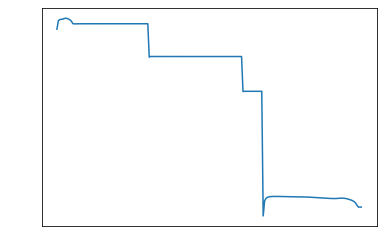

In [1097]:
Ls = np.array(Ls)[1:]
plt.plot([i+1 for i in range(len(Ls))], Ls)

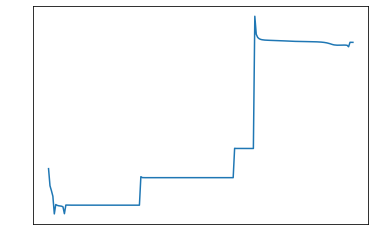

In [1098]:
costs = np.array(costs[1:])
plt.plot([i+1 for i in range(len(costs))], costs)

In [1099]:
print(costs[np.argmin(costs)])
best_params[np.argmin(costs)][0::4]

327.95259697751453


array([0.00082118, 0.143143  , 0.09543524, 0.18874719, 0.00412608,
       0.30246209, 0.22548449, 0.03978072])

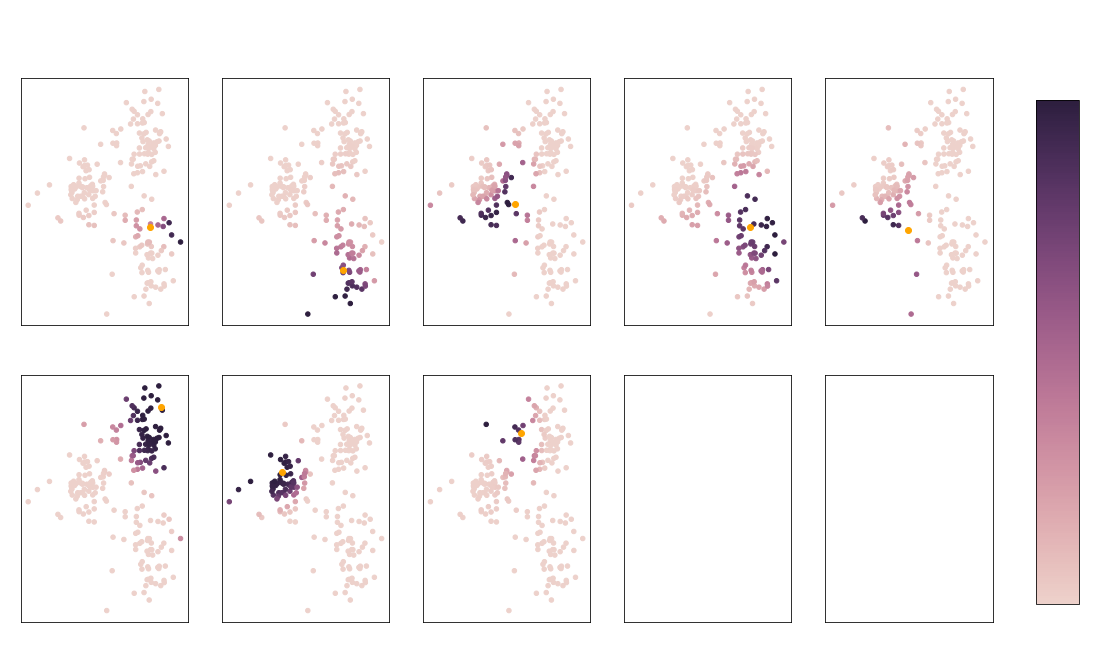

In [1100]:
from plotting.plot_funcs import plot_responsibilities
plot_responsibilities(exp1, best_params[np.argmin(costs)])

In [1101]:
len(costs)
len(best_params)

212

In [1102]:
np.log(0.10230665)

-2.279780603249697

In [ ]:
from em_algorithm.em_funcs import gamma

gamma(X, best_params[np.argmin(costs)], 3)

array([2.07309069e-09, 4.27709398e-50, 1.62610795e-52, 1.78413680e-19,
       5.65218203e-58, 2.45243649e-25, 2.90796008e-40, 4.31583802e-37,
       6.60760548e-39, 1.20043895e-24, 5.56000279e-19, 5.64450340e-48,
       3.30914138e-39, 1.01120050e-47, 1.95340844e-22, 2.44130368e-27,
       3.63356176e-30, 1.39074952e-24, 9.28781488e-30, 9.67157035e-15,
       2.35532033e-40, 4.83445804e-31, 3.20960801e-23, 2.36586035e-64,
       1.34183445e-12, 2.05087892e-10, 2.84455385e-12, 1.56145237e-31,
       6.90260825e-39, 6.22063166e-48, 6.53938289e-16, 2.62137140e-25,
       1.90839202e-40, 2.92705969e-51, 1.97376848e-73, 2.99300117e-12,
       4.26270605e-29, 2.46073531e-25, 3.03482739e-20, 3.05689745e-49,
       1.48618638e-14, 4.55308211e-14, 2.63906463e-22, 1.13681300e-15,
       2.01211607e-35, 1.25922399e-39, 3.13284707e-21, 4.37392164e-10,
       2.79742975e-28, 5.13042877e-53, 3.08250342e-22, 2.39330095e-28,
       1.14040114e-08, 5.17885390e-47, 9.27773589e-24, 2.87885402e-41,
      

In [ ]:
best_params[60][0::4]

array([0.67914778, 0.32085222])